Date: 3/27/21
### Purpose
- Lasso regression using PnL as the target

### Notes
- Terrible model performance: R**2=.50
- Log xform of target didn't work

In [227]:
# k=1
# #check the distribution
# sns.distplot(df['PnL'], color = 'purple')
# plt.xticks(rotation=90);
# plt.title('Figure {}'.format(k), y=-0.5, fontsize = 16)
# k=k+1

In [228]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 50)

In [229]:
%%time
df = pd.read_parquet('../data/approved2.parquet', engine='fastparquet')

Wall time: 2.74 s


In [230]:
df.sample(5)

,addr_state,annual_inc,application_type,disbursement_method,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,issue_d,last_pymnt_d,loan_amnt,loan_status,open_acc,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,total_pymnt,verification_status,zip_code,days_since_first_credit,fico_score_average
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29214563,CO,54000.0,Individual,Cash,16.00,1980-08-01,4,Service,679.0,675.0,A,OWN,w,1.0,252.14,8.39,2014-10-01,2017-05-01,8000.0,1,8.0,1.0,0.0,debt_consolidation,5,36,9053.910512,Source Verified,802xx,12479,677.0
46255710,NY,80000.0,Individual,Cash,16.59,2002-04-01,0,registered nurse case manager,669.0,665.0,D,MORTGAGE,f,3.0,714.43,17.86,2015-04-01,2016-12-01,19800.0,0,22.0,1.0,1.0,home_improvement,20,36,12225.660000,Verified,125xx,4748,667.0
3374858,MD,85800.0,Individual,Cash,16.04,1989-10-01,7,B&B A/C,704.0,700.0,A,MORTGAGE,f,0.0,500.65,7.90,2013-03-01,2014-12-01,16000.0,1,10.0,0.0,0.0,credit_card,4,36,17641.997194,Not Verified,209xx,8552,702.0
55330617,TX,57500.0,Individual,Cash,39.82,1998-07-01,0,Teacher,689.0,685.0,D,RENT,w,3.0,298.17,16.99,2015-07-01,2015-11-01,12000.0,1,27.0,0.0,0.0,debt_consolidation,18,60,12708.220000,Verified,780xx,6209,687.0
72183746,LA,57600.0,Individual,Cash,20.52,2006-04-01,4,Deputy Clerk,759.0,755.0,A,MORTGAGE,w,0.0,361.38,5.32,2016-02-01,2016-11-01,12000.0,1,11.0,0.0,0.0,debt_consolidation,1,36,12442.980000,Not Verified,700xx,3593,757.0


inq_last_6mths        1
zip_code              1
last_pymnt_d       2087
emp_title         83045
dtype: int64

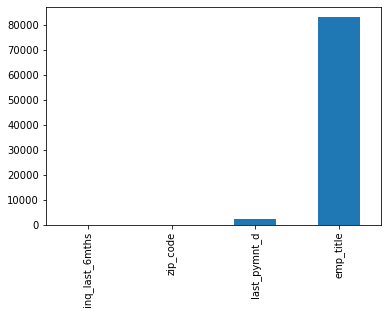

In [231]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
missing

### Feature Engineering

In [232]:
df.drop(df[df['last_pymnt_d'].isna()].index, inplace=True)
df.drop(df[df['inq_last_6mths'].isna()].index, inplace=True)

df['duration']=df['last_pymnt_d']-df['issue_d']
df['duration'] = (df['duration'] / np.timedelta64(1,'D')).astype(int)

df['PnL']=df['total_pymnt']-df['loan_amnt']
# df.drop(df[df['PnL']==0].index, inplace=True)
# df['PnL']=np.log(df['PnL'])
# df.drop(df[df['PnL'].isna()].index, inplace=True)

In [233]:
df.PnL.sort_values(ascending=True)

id
129425077   -39970.000000
141156167   -39800.000000
135732086   -39308.450000
124963635   -39217.660000
125093154   -39182.070000
                 ...     
7935889      24786.287187
8609625      24812.838972
6736724      24918.875391
7710894      25053.599040
6727208      25105.015615
Name: PnL, Length: 1300995, dtype: float64

### Convert Ordinals

In [234]:
# # sub_grade
# df.sub_grade.replace({'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5, 'B1':6, 'B2':7, 
#                       'B3':8, 'B4':9, 'B5':10, 'C1':11, 'C2':12, 'C3':13, 'C4':14, 
#                       'C5':15, 'D1':16, 'D2':17, 'D3':18, 'D4':19, 'D5':20, 'E1':21, 
#                       'E2':22, 'E3':23, 'E4':24, 'E5':25}, inplace=True)

# disbursement_method
df.disbursement_method.replace({'Cash':0,'DirectPay':1},inplace=True)

# verification_status
df.verification_status.replace({'Source Verified':'Verified'},inplace=True)
df.verification_status.replace({'Not Verified':0,'Verified':1}, inplace=True)

# initial_list_status
df.initial_list_status.replace({'w':0,'f':1}, inplace=True)

# application_type
df.application_type.replace({'Individual':0,'Joint App':1}, inplace=True)

### Dummification

In [235]:
dummies=['purpose','addr_state','home_ownership']

for d in dummies:
    temp = pd.get_dummies(df[d], prefix=d, prefix_sep='__')
    temp = temp.drop(d+'__'+str(df[d].mode()[0]), axis=1)
    #drop the most common one (mode), making it the base case
    df = pd.concat([df.drop(d, axis=1),temp], axis=1)
    #merge back with main df

### Filter for years

In [236]:
df= df.loc[df['issue_d'].dt.year.between(2007,2015)]

In [237]:
df.issue_d.dt.year.count()

799772

### Drop Columns

In [238]:
df.drop(['emp_title','zip_code','grade','issue_d','earliest_cr_line','fico_range_high',
         'fico_range_low','installment','last_pymnt_d','total_pymnt','duration'],axis=1, inplace=True)

### Drop emp_length==-1

In [239]:
df.drop(df[df['emp_length']==-1].index, inplace=True)

In [240]:
df = df.dropna(how='all')

### Drop the 60month product

In [241]:
df = df.loc[df['term']==36]
df.drop('term', axis=1, inplace=True)

# Modelling

### create target and features

In [242]:
target = df['PnL']

In [243]:
features = df.drop(['PnL'], axis=1)

### note the reduced train_size of .10

In [244]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, train_size=.50 )

In [245]:
lasso = Lasso(normalize=True)

In [ ]:
%%time
alphas = np.linspace(0.000001,100,50)
grid = GridSearchCV(estimator=lasso, param_grid={'alpha':alphas}, cv=5, return_train_score=True)
grid.fit(Xtrain, ytrain)

In [ ]:
grid.score(Xtest,ytest)

In [ ]:
best_model = grid.best_estimator_
best_model.score(Xtest, ytest)

In [ ]:
print(grid.best_score_)
print(grid.best_params_)

In [ ]:
lasso2 = Lasso(alpha=2.3000000000000003e-05, normalize=True)
lasso2.get_params()

In [56]:
print('the intercept is: %.2f' %(grid.intercept_))
coefs = pd.Series(grid.coef_, index=features.columns)

AttributeError: 'GridSearchCV' object has no attribute 'intercept_'

In [82]:
Xtrain

,annual_inc,application_type,disbursement_method,dti,emp_length,initial_list_status,inq_last_6mths,int_rate,loan_amnt,loan_status,open_acc,pub_rec,pub_rec_bankruptcies,sub_grade,verification_status,days_since_first_credit,fico_score_average,duration,purpose__car,purpose__credit_card,purpose__educational,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,...,addr_state__NJ,addr_state__NM,addr_state__NV,addr_state__NY,addr_state__OH,addr_state__OK,addr_state__OR,addr_state__PA,addr_state__RI,addr_state__SC,addr_state__SD,addr_state__TN,addr_state__TX,addr_state__UT,addr_state__VA,addr_state__VT,addr_state__WA,addr_state__WI,addr_state__WV,addr_state__WY,home_ownership__ANY,home_ownership__NONE,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40027452,65000.0,0,0,7.68,3,0,0.0,13.99,6625.0,1,5.0,2.0,2.0,14,1,6485,682.0,120,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38617670,133000.0,0,0,32.84,10,1,0.0,9.49,4000.0,1,19.0,0.0,0.0,7,1,7792,712.0,59,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44137268,18000.0,0,0,27.87,0,1,0.0,18.25,6475.0,1,4.0,0.0,0.0,21,1,3711,682.0,1096,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
641807,34900.0,0,0,22.69,6,1,2.0,9.99,4000.0,1,13.0,0.0,0.0,9,0,3106,687.0,670,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
13457875,61000.0,0,0,18.73,2,1,0.0,12.49,20000.0,1,22.0,0.0,0.0,9,1,9832,662.0,1037,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506555,78000.0,0,0,8.91,7,1,2.0,13.11,4725.0,0,12.0,1.0,1.0,9,1,3927,687.0,546,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6784687,30000.0,0,0,21.24,0,1,2.0,18.85,7750.0,0,9.0,1.0,1.0,18,0,12022,672.0,334,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
32179125,54000.0,0,0,23.73,4,0,0.0,17.57,3525.0,0,11.0,0.0,0.0,19,1,3621,682.0,517,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
coefs = pd.DataFrame(abs(best_model.coef_).T, index=features.columns)

In [ ]:
coefs.sort_values(0, ascending=False).head(10)

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cmat = confusion_matrix(ytest,best_model.predict(Xtest))

#Label the confusion matrix
pd.DataFrame(cmat, columns = [f'Pred_{label}' for label in best_model.classes_],
             index = [f'True_{label}' for label in best_model.classes_])


### Best model is one that strikes good balance of a high "pred_1 precision" and a high "loan approval rate"

In [ ]:
cmat=cmat
print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, best_model.predict(Xtest)))

### Merge test results back into the df to investigate the 'fully paid fails'

In [ ]:
model_results = pd.Series(best_model.predict(Xtest), index = Xtest.index, name="loan_status_predict")

In [ ]:
df2 = pd.concat([Xtest, ytest, model_results], axis=1 )

In [ ]:
fails = df2.loc[(df2['loan_status'] == 0) & (df2['loan_status_predict'] == 1)]
fails

### PnL analysis

In [ ]:
model_port = df2.loc[df2['loan_status_predict'] == 1]

In [ ]:
PnL = df_full['PnL']

In [ ]:
model_port = model_port.merge(PnL, how='inner',left_index=True,right_index=True)

In [ ]:
print(f'Total investment for Model Portfolio: {model_port.loan_amnt.sum():.0f}')
print(f'Total PnL for Model Portfolio: {model_port.PnL.sum():.0f}')
print(f'Return for Model Portfolio: {(model_port.PnL.sum()/model_port.loan_amnt.sum())*100:.2f}%')

In [ ]:
null_port = df2.merge(PnL, how='inner',left_index=True,right_index=True)

In [ ]:
print(f'Total investment for Null Portfolio: {null_port.loan_amnt.sum():.0f}')
print(f'Total PnL for Null Portfolio: {null_port.PnL.sum():.0f}')
print(f'Return for Null Portfolio: {(null_port.PnL.sum()/null_port.loan_amnt.sum())*100:.2f}%')

In [ ]:
null_port.loc[null_port['loan_status_predict'] == 0].PnL.sum()

In [ ]:
null_port.loc[(null_port['loan_status_predict'] == 0) & (null_port['loan_status'] == 0)].PnL.sum()

In [ ]:
null_port.loc[(null_port['loan_status_predict'] == 0) & (null_port['loan_status'] == 1)].PnL.sum()

In [ ]:
null_port.loan_status_predict.value_counts()

### Research the model fails

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
sns.countplot(x=fails['sub_grade'],ax=ax1)
sns.countplot(x=Xtest['sub_grade'],ax=ax2)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="dti", ax=ax1)
sns.histplot(data=Xtest, x="dti", ax=ax2)
plt.xlim(0, 40)
# plt.show()

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="int_rate", ax=ax1)
sns.histplot(data=Xtest, x="int_rate", ax=ax2)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="emp_length", ax=ax1)
sns.histplot(data=Xtest, x="emp_length", ax=ax2)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="fico_score_average", ax=ax1)
sns.histplot(data=Xtest, x="fico_score_average", ax=ax2)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="open_acc", ax=ax1)
sns.histplot(data=Xtest, x="open_acc", ax=ax2)

### change the threshold to improve the pred_1 precision

In [ ]:
probs_positive_class = best_model.predict_proba(Xtest)[:, 1]
prediction = probs_positive_class > .6

In [ ]:
cmat2 = confusion_matrix(ytest, prediction, labels=[0, 1])
pd.DataFrame(cmat2, columns = [f'Pred_{label}' for label in best_model.classes_],
             index = [f'True_{label}' for label in best_model.classes_])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, prediction))

In [ ]:
cmat=cmat2
print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')

### Loop to check thresholds

In [ ]:
thresholds = np.linspace(0.5,1,19)

for i in thresholds:
    probs_positive_class = best_model.predict_proba(Xtest)[:, 1]
    prediction = probs_positive_class > i
    cmat = confusion_matrix(ytest, prediction, labels=[0, 1])
    print(f'threshold:{i:.2f}')
    print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
    print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
    print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')
    print("-"*50)

## ROC Curve

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
# predict probabilities
yhat = logr.predict_proba(Xtest)

In [ ]:
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

In [ ]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, prediction)

In [ ]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### SGD classifier

### Save model in pickle

In [ ]:
filename = 'grid_logr_model.sav'
pickle.dump(grid_logr, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Xtest, ytest)
print(result)